In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from classes.nn_classes import NNmodel
from classes.nn_classes import train_model as train_model_with_batch
from torch.utils.data import Dataset, DataLoader

In [20]:
data_flat = np.loadtxt('labeled_clusters_1000.txt')
positions_from_file = data_flat[:,:24].reshape(-1,12,2)
energies_from_file = data_flat[:,24:25].reshape(-1)
labels_from_file = data_flat[:,-1:].reshape(-1).astype('int')

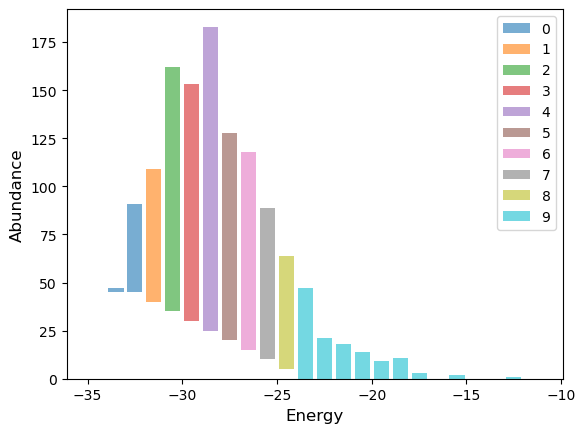

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel("Energy", fontsize=12)
ax.set_ylabel("Abundance", fontsize=12)
energy_range = np.arange(-35,-10, 1)#np.linspace(-40,40, 80)

#for i in range(10):
 #   bins = range(-35,-10)
 #   bars, _ = np.histogram(energies YOUR CODE ,bins=bins)
#    bottom = (9-i)*5
#    ax.bar(np.array(list(bins))[:-1]+0.5,bars,bottom=bottom,alpha=0.6,label=f'{i}')

for label in range(0, 10):
    indices = np.argwhere(labels_from_file == label)
    energies = energies_from_file[indices]
    hist, bin_edges = np.histogram(energies, bins=energy_range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    bottom = (9-label)*5
    ax.bar(bin_centers, hist, label=f"{label}", color=f"C{label}", alpha=0.6, bottom=bottom)
    #ax.bar(bin_centers, hist, label=f"{label}", color=f"C{label}", alpha=0.6)
ax.legend()

In [103]:
class DistanceMoments():
    def __init__(self, beta=3.0) -> None:
        self.beta = beta

    def calculate_moment(self, atom_poses):
        mus_tot = np.zeros(shape=(len(atom_poses), 4))
        for i, atom_pos in enumerate(atom_poses):
            xs, ys = atom_pos[:,0], atom_pos[:,1]
            vec_mean = np.array([np.mean(xs), np.mean(ys)])
            mus = np.zeros(4)
            for j in range(1,5):
                sum_res = np.sum(((xs-vec_mean[0])**2+(ys-vec_mean[1])**2)**j)
                mus[j-1] = self.beta**(-j)*sum_res
            mus_tot[i] = mus
        return mus_tot

In [104]:
dist_mom_calculator = DistanceMoments()
divisions = {"train":(0,800), "val":(800, 900), "test":(900, 1000)}

energies_tot = {}
labels_tot = {}
dist_moms_tot = {}

lens = [800, 100, 100]
for division, l in zip(divisions, lens):
    div0, div1 = divisions[division]
    random_perm = np.random.permutation(l)
    energies_tot[division] = energies_from_file[div0:div1][random_perm]
    labels_tot[division] = labels_from_file[div0:div1][random_perm]
    dist_moms_tot[division] = dist_mom_calculator.calculate_moment(positions_from_file[div0:div1][random_perm])

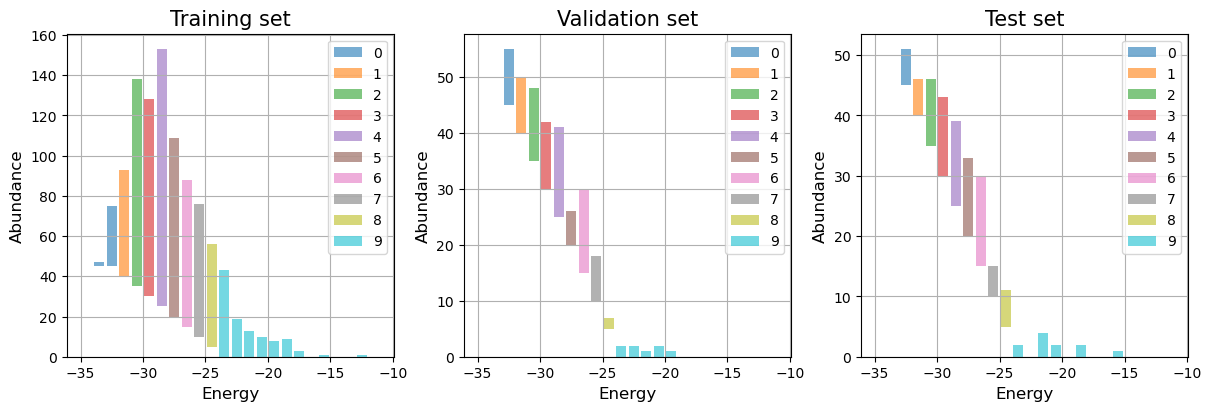

In [105]:
fig, axs = plt.subplots(1,3, figsize=(12,4), layout="constrained")

for ax in axs:
    ax.set_xlabel("Energy", fontsize=12)
    ax.set_ylabel("Abundance", fontsize=12)

energy_range = np.arange(-35,-10, 1)#np.linspace(-40,40, 80)
titles = ["Training set", "Validation set", "Test set"]
for ax, division, title in zip(axs, energies_tot, titles):
    ax.set_title(title, fontsize=15)
    energies = energies_tot[division]
    labels_group = labels_tot[division]
    for i in range(0,10):
        indices = np.argwhere(labels_group == i)
        energies_group = energies[indices]
        hist, bin_edges = np.histogram(energies_group, bins=energy_range)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
        bottom = (9-i)*5
        ax.bar(bin_centers, hist, label=f"{i}", color=f"C{i}", alpha=0.6, bottom=bottom)
    ax.grid()
    ax.legend()

In [106]:
class CustomDataset(Dataset):
    def __init__(self, dist_moms, labels) -> None:
        super().__init__()
        self.dist_moms = dist_moms
        self.labels = labels

    def __getitem__(self, index):
        return self.dist_moms[index], self.labels[index]
    
    def __len__(self):
        return len(self.dist_moms)
    

In [107]:
tot_datasets = {}
tot_loaders = {}

for division in energies_tot:
    tot_datasets[division] = CustomDataset(dist_moms=torch.tensor(dist_moms_tot[division], dtype=torch.float), labels=torch.tensor(labels_tot[division], dtype=torch.long))
    tot_loaders[division] = DataLoader(dataset=tot_datasets[division], batch_size=20, shuffle=False)

In [108]:
class PredictModel(NNmodel):
    def __init__(self, input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias=True) -> None:
        super().__init__(input_dim, output_dim, num_hidden_layers, dim_hiddens, activation_func, bias)
        self.softmax = torch.nn.Softmax(dim=1)
        
    def predict(self, x):
        return torch.argmax(self.softmax(self.forward(x)), dim=1)

N_hiddens = [2,4]
hidden_dims = [6,12]
models = []
model_val_losses = []
model_train_losses = []
model_test_losses = []
for N_hidden in N_hiddens:
    for hidden_dim in hidden_dims:
        model = PredictModel(input_dim=4, output_dim=10, num_hidden_layers=N_hidden, dim_hiddens=hidden_dim, activation_func=torch.nn.SiLU(), bias=True)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
        train_losses, val_losses, test_loss = train_model_with_batch(epochs=10000, model=model, 
                                                  train_loader=tot_loaders["train"], 
                                                  val_loader=tot_loaders["val"],
                                                  test_loader=tot_loaders["test"],
                                                  optimizer=optimizer,
                                                  early_stopping=True,
                                                  patience=500,
                                                  loss_func=torch.nn.CrossEntropyLoss())
        model_test_losses.append(test_loss)
        model_val_losses.append(val_losses)
        model_train_losses.append(train_losses)
        models.append(model)

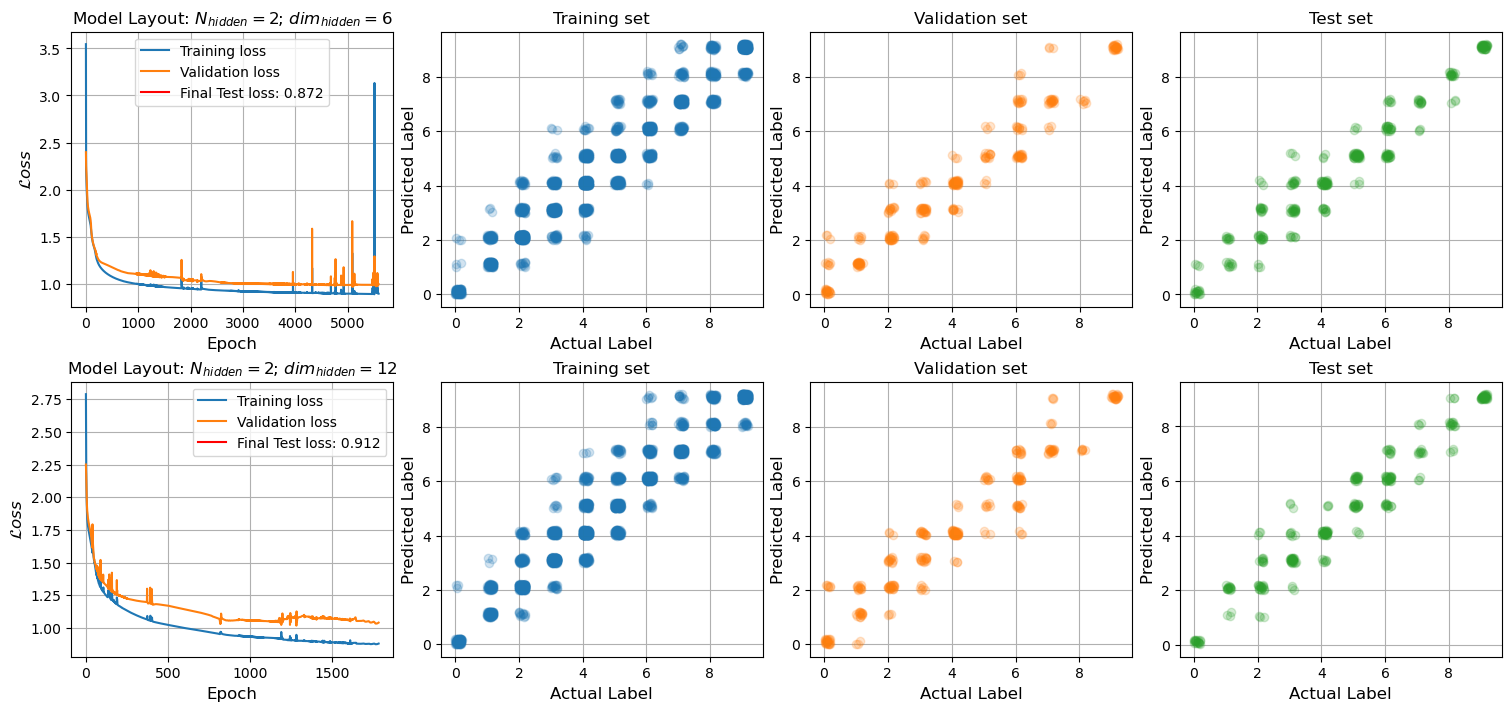

In [109]:
fig, axs = plt.subplots(2,4, figsize=(15, 7), layout="constrained")

titles = ["Training set", "Validation set", "Test set"]

for ax_row, model, model_train_loss, model_val_loss, model_test_loss in zip(axs, models[0:2], model_train_losses[0:2], model_val_losses[0:2], model_test_losses[0:2]):
    ax_row[0].set_xlabel("Epoch", fontsize=12)
    ax_row[0].set_ylabel(r"$\mathcal{L}oss$", fontsize=12)
    ax_row[0].set_title("Model Layout: "+r"$N_{hidden}=$"+f"{len(model.hidden_layers)}; "+r"$dim_{hidden}=$"+f"{len(model.hidden_layers[0].bias)}")
    with torch.no_grad():
        epochs = torch.linspace(0.0, len(model_train_loss), len(model_train_loss))
        ax_row[0].plot(epochs, model_train_loss, label="Training loss")
        ax_row[0].plot(epochs, model_val_loss, label="Validation loss")   
        ax_row[0].plot([], [], c="r", label=f"Final Test loss: {round(model_test_loss.item(),3)}") 
        
    for ax, title in zip(ax_row[1:], titles):
        ax.set_xlabel("True label", fontsize=12)   
        ax.set_ylabel("Predicted label", fontsize=12)
        ax.set_title(title, fontsize=15)
        for i, data_loader, ax, title in zip(range(0,3), [tot_loaders["train"], tot_loaders["val"], tot_loaders["test"]], ax_row[1:], ["Training set", "Validation set", "Test set"]):
            for dist_mom, label in data_loader:
                pred_label = model.predict(dist_mom)
                ax.set_ylabel("Predicted Label")
                ax.set_xlabel("Actual Label")
                ax.set_title(title)
                scale_size = 2e-1
                ax.plot(label+scale_size*torch.rand(len(dist_mom)), pred_label+scale_size*torch.rand(len(dist_mom)), "o", color=f"C{i}", alpha=0.2) 
    ax_row[0].legend()

for ax in axs.flatten():
    ax.grid()


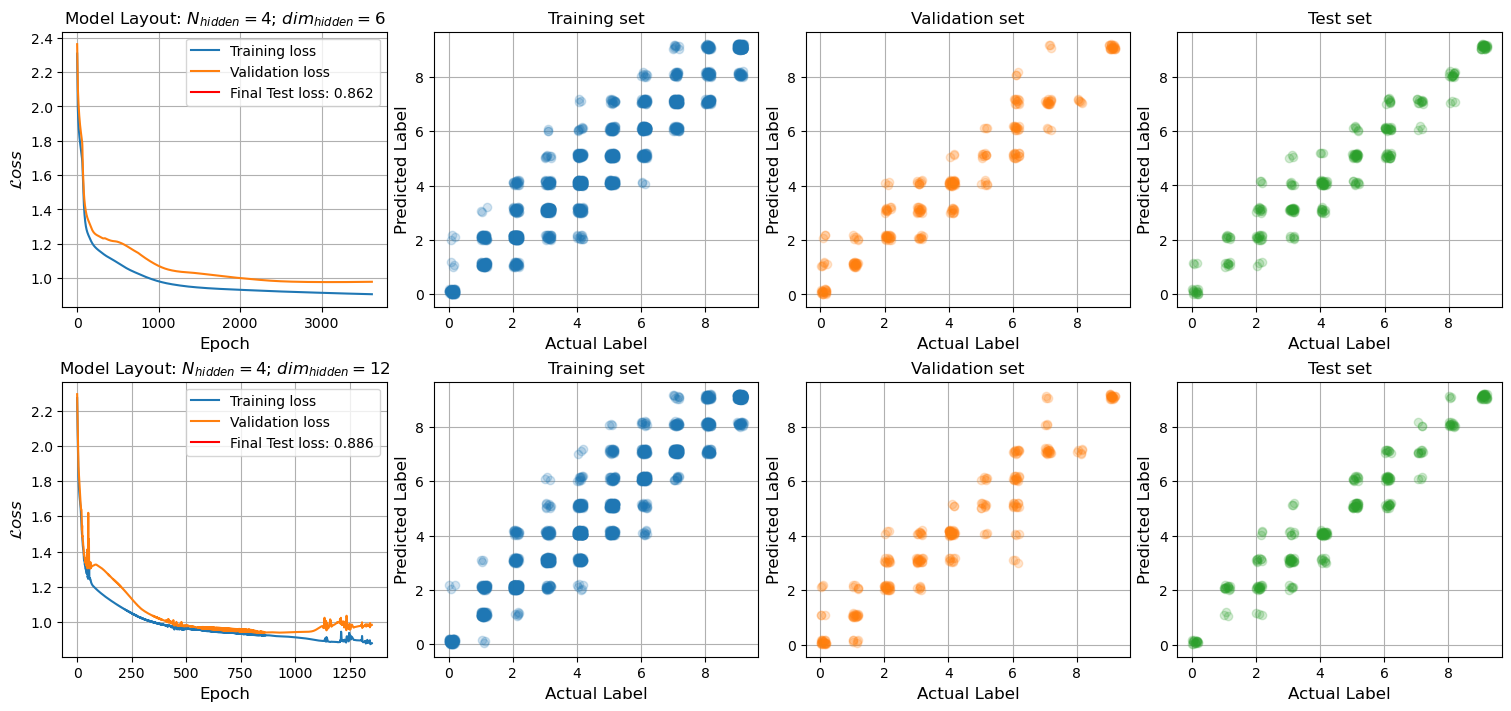

In [110]:
fig, axs = plt.subplots(2,4, figsize=(15, 7), layout="constrained")

titles = ["Training set", "Validation set", "Test set"]

for ax_row, model, model_train_loss, model_val_loss, model_test_loss in zip(axs, models[2:4], model_train_losses[2:4], model_val_losses[2:4], model_test_losses[2:4]):
    ax_row[0].set_xlabel("Epoch", fontsize=12)
    ax_row[0].set_ylabel(r"$\mathcal{L}oss$", fontsize=12)
    ax_row[0].set_title("Model Layout: "+r"$N_{hidden}=$"+f"{len(model.hidden_layers)}; "+r"$dim_{hidden}=$"+f"{len(model.hidden_layers[0].bias)}")
    with torch.no_grad():
        epochs = torch.linspace(0.0, len(model_train_loss), len(model_train_loss))
        ax_row[0].plot(epochs, model_train_loss, label="Training loss")
        ax_row[0].plot(epochs, model_val_loss, label="Validation loss")   
        ax_row[0].plot([], [], c="r", label=f"Final Test loss: {round(model_test_loss.item(),3)}") 
        
    for ax, title in zip(ax_row[1:], titles):
        ax.set_xlabel("True label", fontsize=12)   
        ax.set_ylabel("Predicted label", fontsize=12)
        ax.set_title(title, fontsize=15)
        for i, data_loader, ax, title in zip(range(0,3), [tot_loaders["train"], tot_loaders["val"], tot_loaders["test"]], ax_row[1:], ["Training set", "Validation set", "Test set"]):
            for dist_mom, label in data_loader:
                pred_label = model.predict(dist_mom)
                ax.set_ylabel("Predicted Label")
                ax.set_xlabel("Actual Label")
                ax.set_title(title)
                scale_size = 2e-1
                ax.plot(label+scale_size*torch.rand(len(dist_mom)), pred_label+scale_size*torch.rand(len(dist_mom)), "o", color=f"C{i}", alpha=0.2) 
    ax_row[0].legend()

for ax in axs.flatten():
    ax.grid()

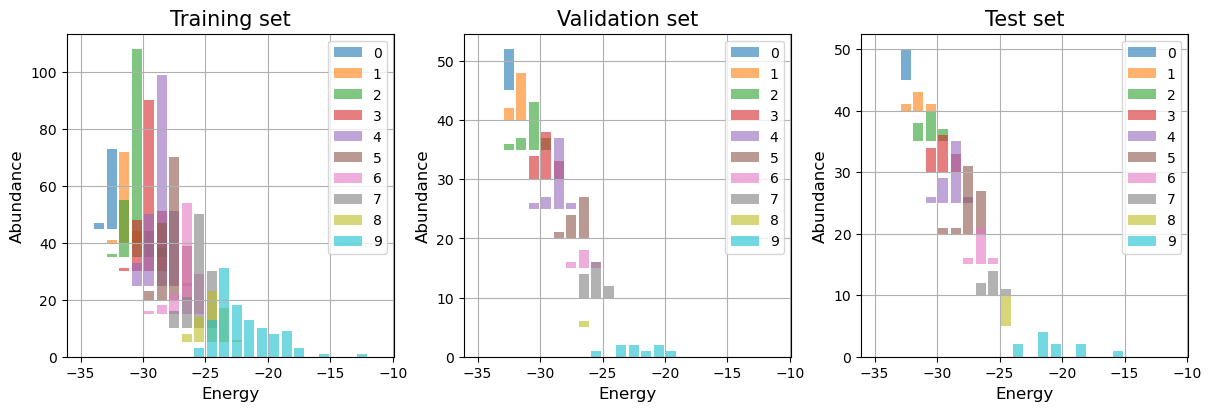

In [116]:
fig, axs = plt.subplots(1,3, figsize=(12,4), layout="constrained")

for ax in axs:
    ax.set_xlabel("Energy", fontsize=12)
    ax.set_ylabel("Abundance", fontsize=12)

model_for_pred = models[0]

energy_range = torch.arange(-35,-10, 1, dtype=torch.float)#np.linspace(-40,40, 80)
titles = ["Training set", "Validation set", "Test set"]
for ax, division, title in zip(axs, energies_tot, titles):
    ax.set_title(title, fontsize=15)
    energies = torch.tensor(energies_tot[division], dtype=torch.float)
    dataloader = tot_loaders[division]
    dist_moms_plot = torch.zeros(len(dataloader)*dataloader.batch_size, 4)
    i = 0
    for dist_moms, _ in dataloader.dataset:
        dist_moms_plot[i] = dist_moms
        i+=1
    labels_for_plot = model_for_pred.predict(dist_moms_plot)
    for i in range(0,10):
        indices = torch.argwhere(labels_for_plot == i)
        energies_for_plot = energies[indices]
        hist, bin_edges = torch.histogram(energies_for_plot, bins=energy_range)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
        bottom = (9-i)*5
        ax.bar(bin_centers, hist, label=f"{i}", color=f"C{i}", alpha=0.6, bottom=bottom)
    ax.grid()
    ax.legend()

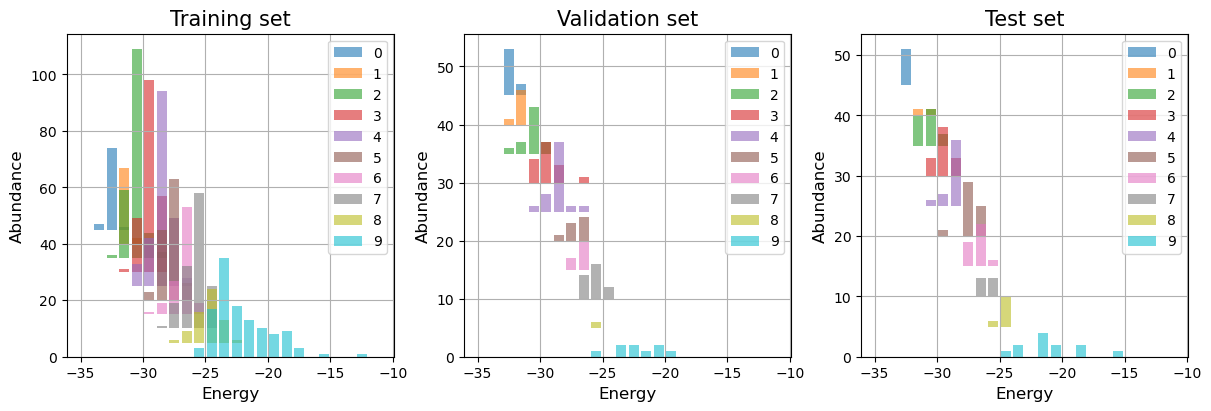

In [118]:
fig, axs = plt.subplots(1,3, figsize=(12,4), layout="constrained")

for ax in axs:
    ax.set_xlabel("Energy", fontsize=12)
    ax.set_ylabel("Abundance", fontsize=12)

model_for_pred = models[3]

energy_range = torch.arange(-35,-10, 1, dtype=torch.float)#np.linspace(-40,40, 80)
titles = ["Training set", "Validation set", "Test set"]
for ax, division, title in zip(axs, energies_tot, titles):
    ax.set_title(title, fontsize=15)
    energies = torch.tensor(energies_tot[division], dtype=torch.float)
    dataloader = tot_loaders[division]
    dist_moms_plot = torch.zeros(len(dataloader)*dataloader.batch_size, 4)
    i = 0
    for dist_moms, _ in dataloader.dataset:
        dist_moms_plot[i] = dist_moms
        i+=1
    labels_for_plot = model_for_pred.predict(dist_moms_plot)
    for i in range(0,10):
        indices = torch.argwhere(labels_for_plot == i)
        energies_for_plot = energies[indices]
        hist, bin_edges = torch.histogram(energies_for_plot, bins=energy_range)
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
        bottom = (9-i)*5
        ax.bar(bin_centers, hist, label=f"{i}", color=f"C{i}", alpha=0.6, bottom=bottom)
    ax.grid()
    ax.legend()